In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
class TitanicDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.FloatTensor(X)
    self.y = torch.LongTensor(y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    feature = self.X[idx]
    target = self.y[idx]
    return {'input': feature, 'target': target}

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str

class TitanicTestDataset(Dataset):
  def __init__(self, X):
    self.X = torch.FloatTensor(X)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    feature = self.X[idx]
    return {'input': feature}

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}".format(
      len(self.X), self.X.shape
    )
    return str


In [3]:
def get_preprocessed_dataset():
    #CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))

    #train_data_path = os.path.join(CURRENT_FILE_PATH, "train.csv")
    #test_data_path = os.path.join(CURRENT_FILE_PATH, "test.csv")

    #train_df = pd.read_csv(train_data_path)
    #test_df = pd.read_csv(test_data_path)
    #jupyter __file__ 위치지정 사용불가
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')

    all_df = pd.concat([train_df, test_df], sort=False)

    all_df = get_preprocessed_dataset_1(all_df)

    all_df = get_preprocessed_dataset_2(all_df)

    all_df = get_preprocessed_dataset_3(all_df)

    all_df = get_preprocessed_dataset_4(all_df)

    all_df = get_preprocessed_dataset_5(all_df)

    #출발항 결측값 2개 제거
    all_df['Embarked'].replace("missing", np.nan, inplace=True)
    all_df.dropna(subset=['Embarked'], inplace=True)
    #print(all_df['Embarked'].value_counts())
    
    all_df = get_preprocessed_dataset_6(all_df)


    train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    train_y = train_df["Survived"]

    test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

    dataset = TitanicDataset(train_X.values, train_y.values)
    #print(dataset)
    train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])
    test_dataset = TitanicTestDataset(test_X.values)
    #print(test_dataset)

    return train_dataset, validation_dataset, test_dataset


In [4]:
def get_preprocessed_dataset_1(all_df):
    # Pclass별 Fare 평균값을 사용하여 Fare 결측치 메우기
    Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
    Fare_mean.columns = ["Pclass", "Fare_mean"]
    all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
    all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]

    return all_df


def get_preprocessed_dataset_2(all_df):
    # name을 세 개의 컬럼으로 분리하여 다시 all_df에 합침
    # name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)
    # name_df.columns = ["family_name", "honorific", "name"]
    # name_df["family_name"] = name_df["family_name"].str.strip()
    # name_df["honorific"] = name_df["honorific"].str.strip()
    # name_df["name"] = name_df["name"].str.strip()
    # all_df = pd.concat([all_df, name_df], axis=1)
    
    # name에서 honorific만 추출 
    all_df['honorific'] = all_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    return all_df


def get_preprocessed_dataset_3(all_df):
    # honorific별 Age 평균값을 사용하여 Age 결측치 메우기
    honorific_age_mean = all_df[["honorific", "Age"]].groupby("honorific").median().round().reset_index()
    honorific_age_mean.columns = ["honorific", "honorific_age_mean" ]
    all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")
    all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_age_mean"]
    all_df = all_df.drop(["honorific_age_mean"], axis=1)

    return all_df


def get_preprocessed_dataset_4(all_df):
    # 가족수(family_num) 컬럼 새롭게 추가
    all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]

    # 혼자탑승(alone) 컬럼 새롭게 추가
    all_df.loc[all_df["family_num"] == 0, "alone"] = 1
    all_df["alone"].fillna(0, inplace=True)

    # 학습에 불필요한 컬럼 제거
    all_df = all_df.drop(["PassengerId", "Name", "Ticket", "Cabin", "Fare_mean"], axis=1)

    return all_df


def get_preprocessed_dataset_5(all_df):
    # honorific 값 개수 줄이기
    all_df.loc[
    ~(
            (all_df["honorific"] == "Mr") |
            (all_df["honorific"] == "Miss") |
            (all_df["honorific"] == "Mrs") |
            (all_df["honorific"] == "Master")
    ),
    "honorific"
    ] = "other"
    all_df["Embarked"].fillna("missing", inplace=True)

    return all_df


def get_preprocessed_dataset_6(all_df):
    # 카테고리 변수를 LabelEncoder를 사용하여 수치값으로 변경하기
    category_features = all_df.columns[all_df.dtypes == "object"]
    from sklearn.preprocessing import LabelEncoder
    for category_feature in category_features:
        le = LabelEncoder()
        if all_df[category_feature].dtypes == "object":
          le = le.fit(all_df[category_feature])
          all_df[category_feature] = le.transform(all_df[category_feature])

    return all_df


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


In [6]:
train_df, val_df, test_df = get_preprocessed_dataset()

In [7]:
print(train_df[:5])

{'input': tensor([[ 1.0000,  0.0000, 54.0000,  1.0000,  0.0000, 78.2667,  0.0000,  1.0000,
          1.0000,  0.0000],
        [ 1.0000,  1.0000, 25.0000,  1.0000,  0.0000, 91.0792,  0.0000,  2.0000,
          1.0000,  0.0000],
        [ 3.0000,  0.0000, 18.0000,  2.0000,  0.0000, 18.0000,  2.0000,  1.0000,
          2.0000,  0.0000],
        [ 2.0000,  0.0000, 36.0000,  0.0000,  0.0000, 13.0000,  2.0000,  3.0000,
          0.0000,  1.0000],
        [ 2.0000,  1.0000,  0.6700,  1.0000,  1.0000, 14.5000,  2.0000,  0.0000,
          2.0000,  0.0000]]), 'target': tensor([0, 1, 0, 0, 1])}


In [8]:
print(val_df[:5])

{'input': tensor([[  1.0000,   1.0000,  47.0000,   0.0000,   0.0000,  38.5000,   2.0000,
           2.0000,   0.0000,   1.0000],
        [  2.0000,   1.0000,  39.0000,   0.0000,   0.0000,  13.0000,   2.0000,
           2.0000,   0.0000,   1.0000],
        [  1.0000,   0.0000,  58.0000,   0.0000,   1.0000, 153.4625,   2.0000,
           3.0000,   1.0000,   0.0000],
        [  3.0000,   1.0000,  24.0000,   1.0000,   0.0000,  16.1000,   2.0000,
           2.0000,   1.0000,   0.0000],
        [  1.0000,   0.0000,  29.0000,   0.0000,   0.0000, 211.3375,   2.0000,
           1.0000,   0.0000,   1.0000]]), 'target': tensor([0, 0, 1, 1, 0])}


In [9]:
plt.style.use('ggplot')
sns.set()
sns.set_palette("Set2")

def chart(dataset, feature_index, feature_name):
    # 생존자와 사망자의 데이터를 담을 딕셔너리 생성
    survived_counts = {}
    dead_counts = {}

    # 데이터셋의 길이만큼 반복하여 데이터 수집
    for i in range(len(dataset)):
        data = dataset[i]  # 데이터 가져오기
        feature_value = data['input'][feature_index].item()  # input에서 feature 값 추출
        survived = data['target'].item()  # target 값 추출

        # 생존자 카운트
        if survived == 1:
            if feature_value in survived_counts:
                survived_counts[feature_value] += 1
            else:
                survived_counts[feature_value] = 1
        # 사망자 카운트
        else:
            if feature_value in dead_counts:
                dead_counts[feature_value] += 1
            else:
                dead_counts[feature_value] = 1

    # DataFrame 생성
    df = pd.DataFrame([survived_counts, dead_counts]).fillna(0)
    df.index = ['Survived', 'Dead']

    # 막대 그래프 그리기
    df.plot(kind='bar', stacked=True)
    plt.title(f'{feature_name} by Survival')
    plt.ylabel('Count')
    plt.xlabel(f'{feature_name}')
    plt.xticks(rotation=45)
    plt.show()

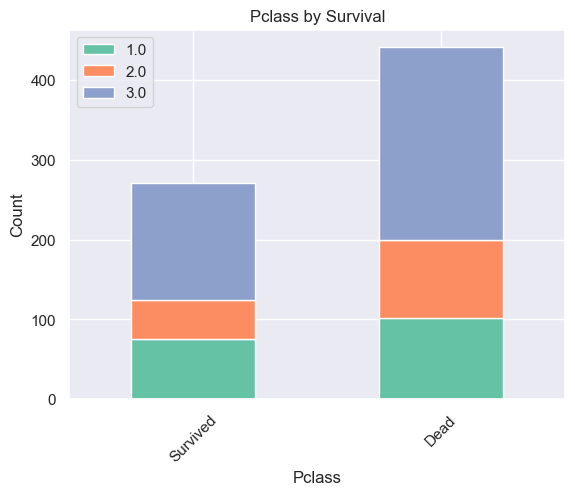

In [10]:
chart(train_df, 0, 'Pclass')

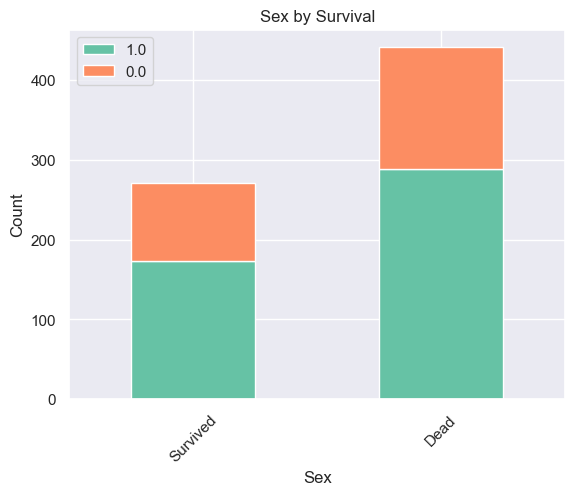

In [11]:
chart(train_df,1, 'Sex')

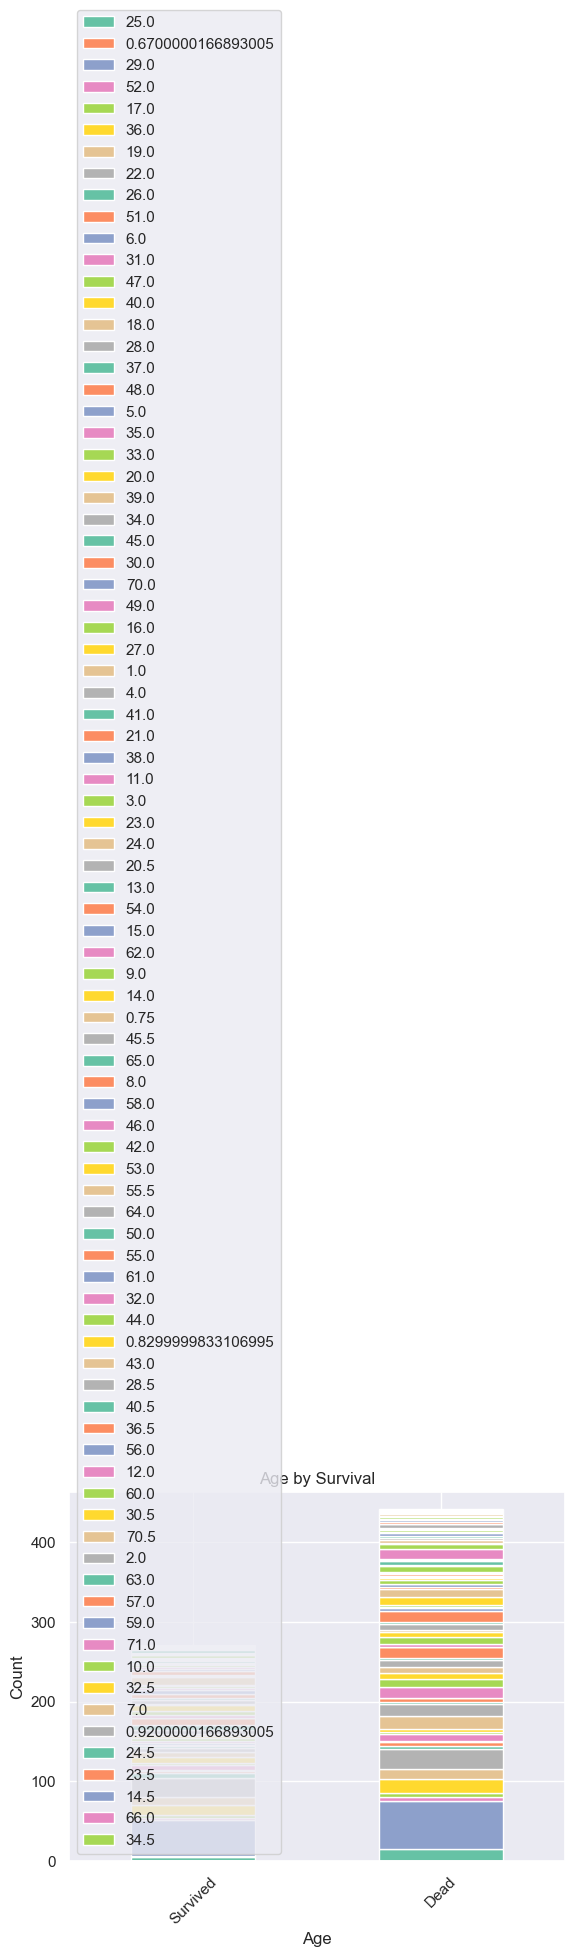

In [12]:
chart(train_df,2, 'Age')

In [13]:
def categorize_age(age): #나이대별로 묶음
    if age <= 12:
        return 0  
    elif age <= 19:
        return 1  
    elif age <= 35:
        return 2  
    elif age <= 55:
        return 3  
    else:
        return 4  
def categorize_age_f(data):
    for item in data:
        age = item['input'][2].item()  # 나이 값을 가져옴 (0번째 요소)
        age_group = categorize_age(age)  # 나이를 범주화
        item['input'][2] = torch.tensor(age_group)  # 나이를 범주화된 값으로 수정
    return data

train_df = categorize_age_f(train_df)

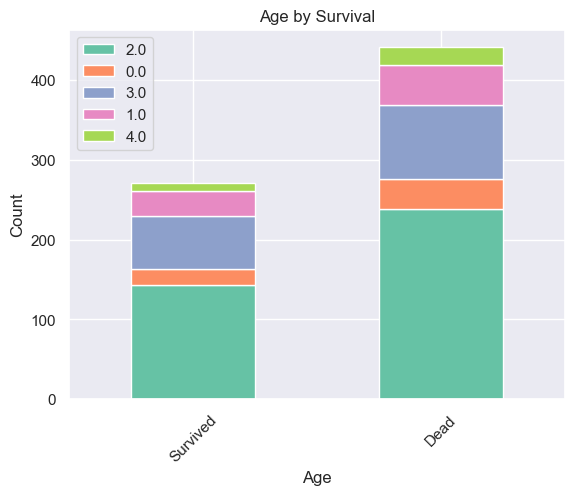

In [14]:
chart(train_df, 2, 'Age')

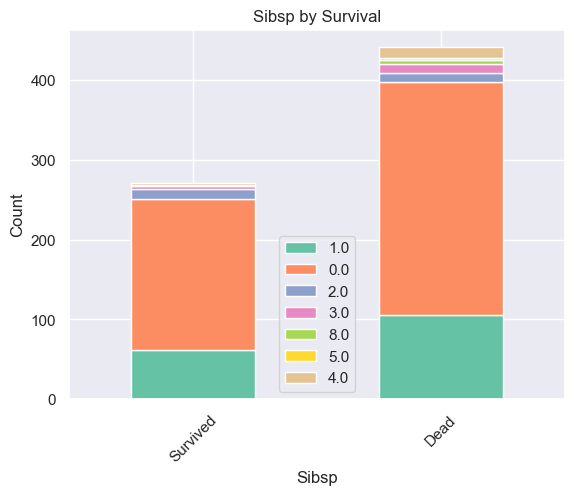

In [15]:
chart(train_df, 3, 'Sibsp')

In [16]:
def categorize_sibsp(sibsp):
    if sibsp <= 0:
        return 0  
    elif sibsp <= 1:
        return 1 
    elif sibsp <= 2:
        return 2
    else:
        return 3  # 나머지
def categorize_sibsp_f(data):
    for item in data:
        sibsp = item['input'][3].item()  # sibsp(3번째 요소)
        sibsp_group = categorize_sibsp(sibsp)  # 범주화
        item['input'][3] = torch.tensor(sibsp_group)  # 범주화된 값으로 수정
    return data

train_df = categorize_sibsp_f(train_df)

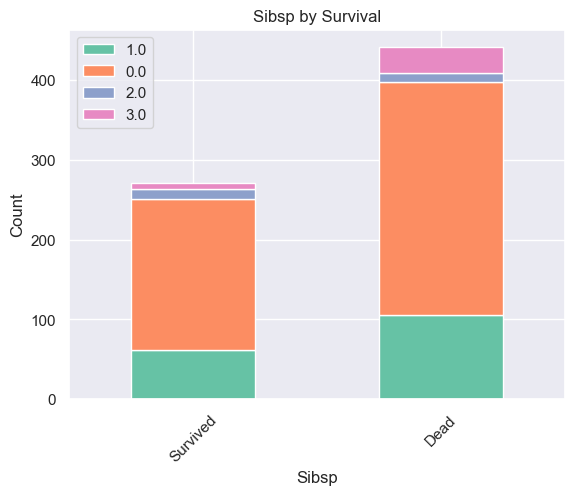

In [17]:
chart(train_df, 3, 'Sibsp')

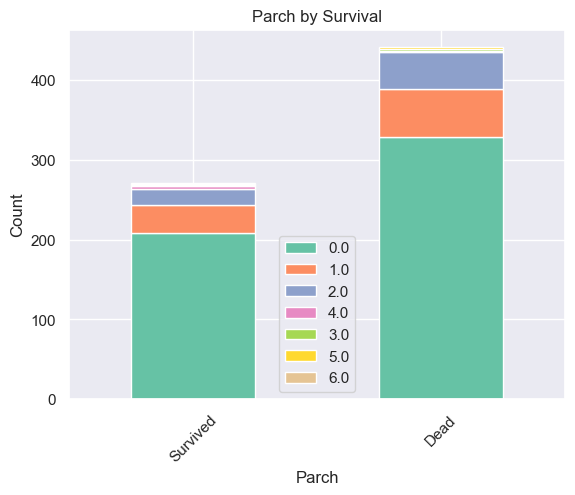

In [18]:
chart(train_df, 4, 'Parch')

In [19]:
def categorize_Parch(Parch):
    if Parch <= 0:
        return 0  
    elif Parch <= 1:
        return 1 
    elif Parch <= 2:
        return 2
    else:
        return 3  # 나머지
def categorize_Parch_f(data):
    for item in data:
        Parch = item['input'][4].item()  # Parch(3번째 요소)
        Parch_group = categorize_Parch(Parch)  # 범주화
        item['input'][4] = torch.tensor(Parch_group)  # 범주화된 값으로 수정
    return data
    
train_df = categorize_Parch_f(train_df)

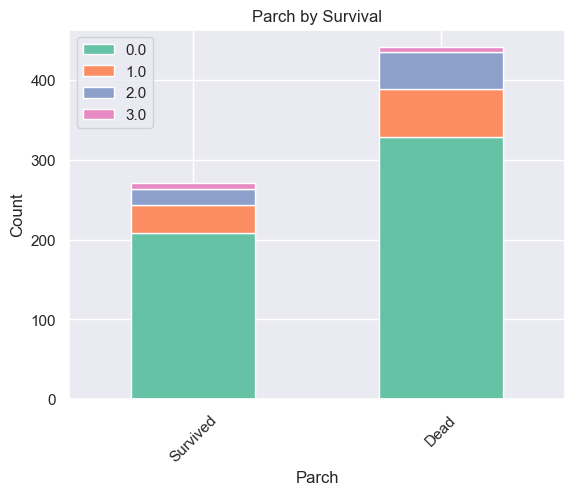

In [20]:
chart(train_df, 4, 'Parch')

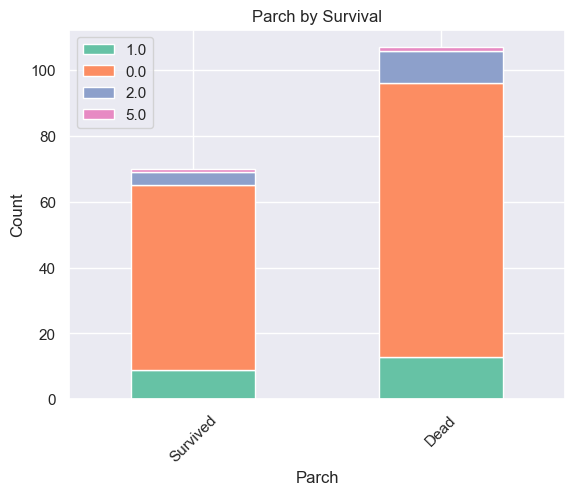

In [21]:
chart(val_df, 4, 'Parch')

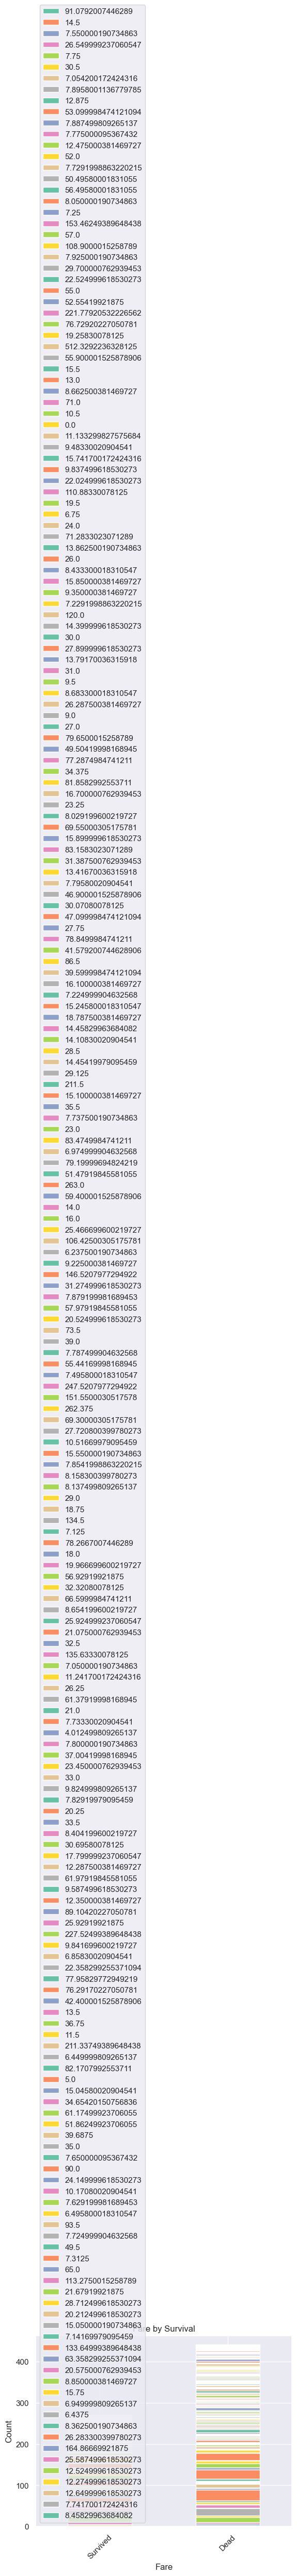

In [22]:
chart(train_df, 5, 'Fare')

In [23]:
def categorize_fare(fare):
    if fare <= 10:
        return 0  
    elif fare <= 30:
        return 1 
    elif fare <= 50:
        return 2
    elif fare <= 100:
        return 3
    else:
        return 4  # 나머지
def categorize_fare_f(data):
    for item in data:
        fare = item['input'][5].item()  # fare(5번째 요소)
        fare_group = categorize_fare(fare)  # 범주화
        item['input'][5] = torch.tensor(fare_group)  #범주화된 값으로 수정
    return data
train_df = categorize_fare_f(train_df)

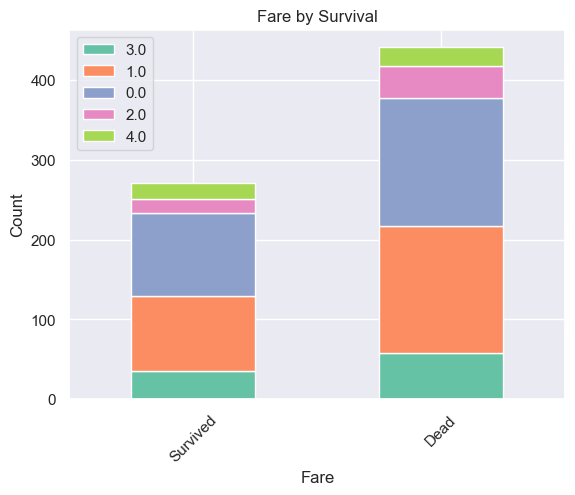

In [24]:
chart(train_df, 5, 'Fare')

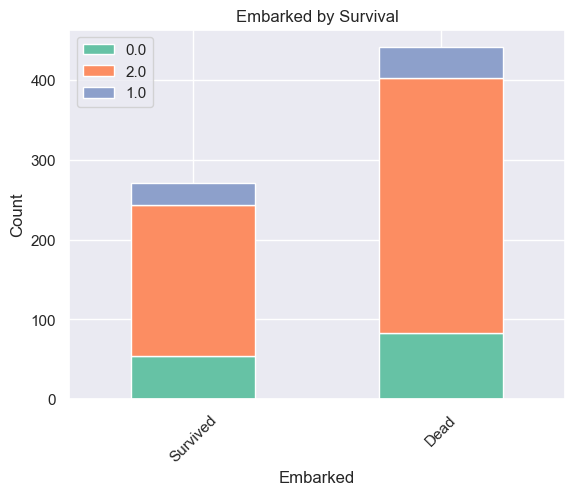

In [25]:
chart(train_df, 6, 'Embarked')

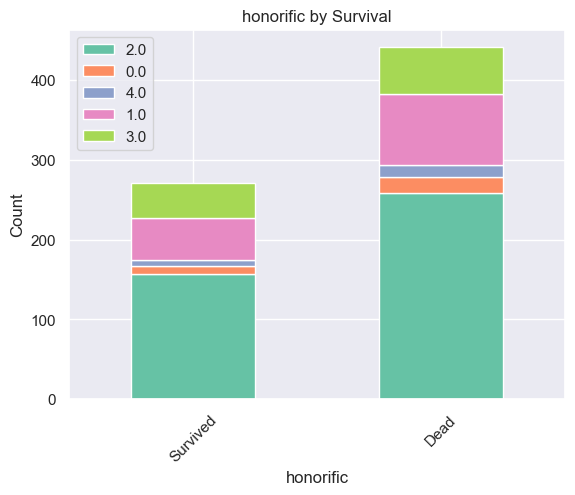

In [26]:
chart(train_df, 7, 'honorific')

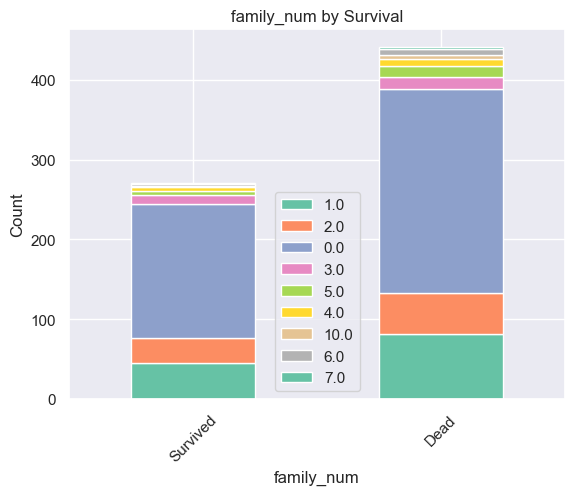

In [27]:
chart(train_df, 8, 'family_num')

In [28]:
def categorize_family(family):
    if family <= 0:
        return 0  
    elif family <= 1:
        return 1 
    elif family <= 2:
        return 2
    else:
        return 3  # 나머지
def categorize_family_f(data):
    for item in data:
        family = item['input'][8].item()  # family(8번째 요소)
        family_group = categorize_family(family)  # 범주화
        item['input'][8] = torch.tensor(family_group)  # 범주화된 값으로 수정
    return data

train_df = categorize_family_f(train_df)

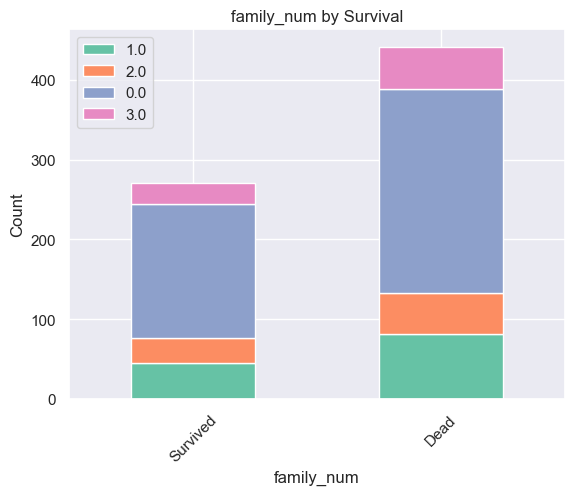

In [29]:
chart(train_df, 8, 'family_num')

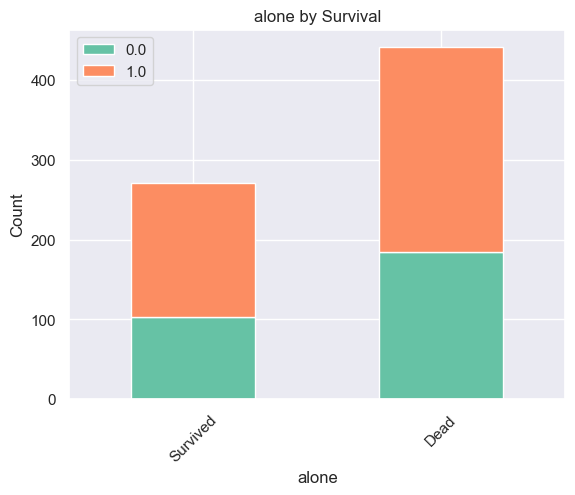

In [30]:
chart(train_df, 9, 'alone')

In [31]:
print(train_df[:10])

{'input': tensor([[1., 0., 3., 1., 0., 3., 0., 1., 1., 0.],
        [1., 1., 2., 1., 0., 3., 0., 2., 1., 0.],
        [3., 0., 1., 2., 0., 1., 2., 1., 2., 0.],
        [2., 0., 3., 0., 0., 1., 2., 3., 0., 1.],
        [2., 1., 0., 1., 1., 1., 2., 0., 2., 0.],
        [3., 1., 2., 1., 0., 1., 2., 2., 1., 0.],
        [1., 0., 2., 0., 0., 3., 0., 1., 0., 1.],
        [3., 1., 2., 0., 0., 0., 2., 2., 0., 1.],
        [1., 0., 2., 3., 2., 4., 2., 1., 3., 0.],
        [1., 1., 2., 0., 0., 1., 2., 2., 0., 1.]]), 'target': tensor([0, 1, 0, 0, 1, 0, 0, 1, 0, 1])}


In [32]:
test_df = categorize_age_f(test_df)
test_df = categorize_sibsp_f(test_df)
test_df = categorize_Parch_f(test_df)
test_df = categorize_fare_f(test_df)
test_df = categorize_family_f(test_df)

val_df = categorize_age_f(val_df)
val_df = categorize_sibsp_f(val_df)
val_df = categorize_Parch_f(val_df)
val_df = categorize_fare_f(val_df)
val_df = categorize_family_f(val_df)

In [33]:
print(test_df[:10])

{'input': tensor([[3., 1., 2., 0., 0., 0., 1., 2., 0., 1.],
        [3., 0., 3., 1., 0., 0., 2., 3., 1., 0.],
        [2., 1., 4., 0., 0., 0., 1., 2., 0., 1.],
        [3., 1., 2., 0., 0., 0., 2., 2., 0., 1.],
        [3., 0., 2., 1., 1., 1., 2., 3., 2., 0.],
        [3., 1., 1., 0., 0., 0., 2., 2., 0., 1.],
        [3., 0., 2., 0., 0., 0., 1., 1., 0., 1.],
        [2., 1., 2., 1., 1., 1., 2., 2., 2., 0.],
        [3., 0., 1., 0., 0., 0., 0., 3., 0., 1.],
        [3., 1., 2., 2., 0., 1., 2., 2., 2., 0.]])}


In [34]:
print(val_df[:10])

{'input': tensor([[1., 1., 3., 0., 0., 2., 2., 2., 0., 1.],
        [2., 1., 3., 0., 0., 1., 2., 2., 0., 1.],
        [1., 0., 4., 0., 1., 4., 2., 3., 1., 0.],
        [3., 1., 2., 1., 0., 1., 2., 2., 1., 0.],
        [1., 0., 2., 0., 0., 4., 2., 1., 0., 1.],
        [3., 1., 2., 0., 0., 0., 2., 2., 0., 1.],
        [2., 1., 2., 0., 0., 1., 2., 2., 0., 1.],
        [1., 1., 3., 0., 0., 1., 2., 2., 0., 1.],
        [2., 1., 2., 0., 0., 1., 2., 4., 0., 1.],
        [1., 0., 3., 1., 1., 4., 2., 3., 2., 0.]]), 'target': tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 0])}


--------------------여기까지 데이터 전처리----------------------

In [35]:
from torch import nn

In [36]:
class MyModel(nn.Module):
  def __init__(self, n_input, n_output, activation_function):
        super().__init__()
        self.activation = self.get_activation_function(activation_function)
          
        self.model = nn.Sequential(
            nn.Linear(n_input, 30),
            self.activation,
            nn.Linear(30, 30),
            self.activation,
            nn.Linear(30, n_output),
        )
  def get_activation_function(self, activation):
        if activation == "ReLU":
            return nn.ReLU()
        elif activation == "ELU":
            return nn.ELU()
        elif activation == "LeakyReLU":
            return nn.LeakyReLU()
        elif activation == "PReLU":
            return nn.PReLU()
        else:
            raise ValueError("Unsupported activation function")

  def forward(self, x):
      x = self.model(x)
      return x

In [61]:
def test(test_data_loader):
    print("[TEST]")
    
    my_model = MyModel(n_input=10, n_output=2, activation_function='ReLU')
    my_model.load_state_dict(torch.load("titanic_model.pth", weights_only=True))  # 저장된 가중치 로드
    my_model.eval()  # 평가 모드로 설정
    
    predictions = []
    
    # 테스트 데이터에 대해 예측 수행
    with torch.no_grad():  # 기울기 계산 비활성화
        for batch in test_data_loader:
            inputs = batch['input']
            output_batch = my_model(inputs)  # 모델에 입력 배치 전달
            prediction_batch = torch.argmax(output_batch, dim=1)  # 예측 결과
    
            # 예측 결과를 리스트에 저장
            for idx, prediction in enumerate(prediction_batch):
                predictions.append({"Passengerld": idx + 892, "Survived": prediction.item()})  # 예측과 인덱스를 딕셔너리 형태로 저장
    
    # DataFrame으로 변환하고 CSV 파일로 저장
    df_predictions = pd.DataFrame(predictions)
    df_predictions.to_csv("test_predictions.csv", index=False)  # 인덱스 없이 저장
    print("Predictions saved to test_predictions.csv")



In [38]:
class TitanicDataset(Dataset):
    def __init__(self, data):
        self.inputs = [sample['input'] for sample in data]
        self.targets = [sample['target'] for sample in data]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {"input": torch.tensor(self.inputs[idx], dtype=torch.float32),
                "target": torch.tensor(self.targets[idx], dtype=torch.long)}


In [39]:
print(train_df)

In [55]:
import wandb
import torch.optim as optim
from torch.utils.data import DataLoader

In [56]:
wandb.init(project="titanic")

In [57]:
wandb.config.learning_rate = 0.001 #학습률
wandb.config.epochs = 100 #에포치
wandb.config.batch_size = 16 
wandb.config.activation_function = "ReLU" #학습에 사용할 활성화함수
#wandb.config.activation_function = "ELU"
#wandb.config.activation_function = "LeakyReLU"
#wandb.config.activation_function = "PReLU"

n_input = train_df[0]['input'].shape[0]
n_output = 2
model = MyModel(n_input, n_output, activation_function=wandb.config.activation_function)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate)

train_data_loader = DataLoader(dataset=train_df, batch_size=wandb.config.batch_size, shuffle=True)
validation_data_loader = DataLoader(dataset=val_df, batch_size=wandb.config.batch_size, shuffle=False)


In [58]:
# Initialize Weights and Biases

# Training loop
for epoch in range(wandb.config.epochs):
    model.train()  # 모델을 학습 모드로 설정
    total_train_loss = 0  # 총 학습 손실 초기화

    for batch in train_data_loader:
        inputs = batch['input']
        targets = batch['target']
                
        # Backward and optimize
        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_data_loader)
    
    # 검증 손실 계산
    model.eval()  # 모델을 평가 모드로 설정
    total_val_loss = 0

    with torch.no_grad():  # 기울기 계산 비활성화
        for batch in validation_data_loader:
            inputs = batch['input']
            targets = batch['target']
            outputs = model(inputs)  # Forward pass
            val_loss = loss_function(outputs, targets).item()  # 검증 손실 계산
            total_val_loss += val_loss
            
    avg_val_loss = total_val_loss / len(validation_data_loader)  # 평균 손실 계산

    # 로그 기록
    wandb.log({"train_loss": avg_train_loss, "val_loss": avg_val_loss})
torch.save(model.state_dict(), "titanic_model.pth")
# 실행 종료
wandb.finish()

train_loss,██▇▇▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
val_loss,▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▅▄▅▅▅▆▆█▅▇▆▇▇█
train_loss,0.57849
val_loss,0.70841


In [59]:
test_data_loader = DataLoader(dataset=test_df, batch_size=len(test_df), shuffle=False)

In [62]:
test(test_data_loader)

[TEST]
Predictions saved to test_predictions.csv


숙제 후기
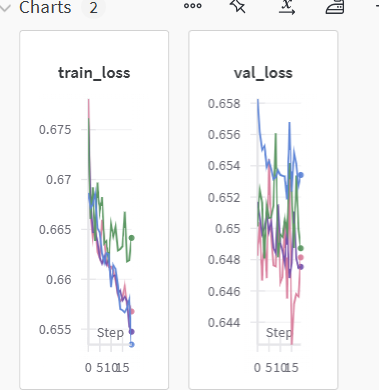
4가지의 활성화 함수를 사용해 20번의 에포치를 돌려본 결과 Lelu가 가장 좋은 결과가 나오는 것을 확인하였습니다
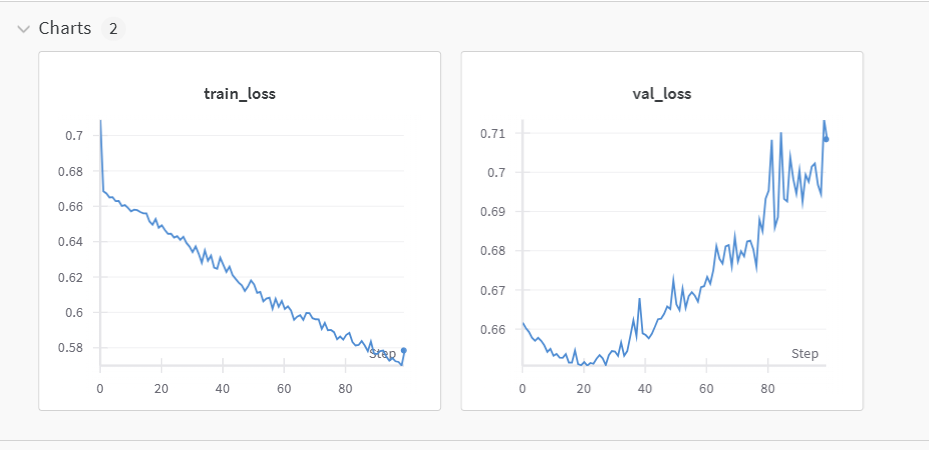
그 이후 Lelu함수를 이용하여 100번의 에포치를 돌려본 결과 14번째 이후 과적합이 발생하는 것을 확인하였고 14번의 학습 한 모델을 가지고 예측 결과를 가지고 예측을 실행하였습니다.
처음에 학습을 실행하고 wandb에 그래프를 띄웠을때는 loss값들이 제멋대로 되서 학습 데이터가 잘못된 부분이 있는 것 같다고 생각하였고 거기에 추가한 것이 출발항 결측값이 2개 있어서 그것을 제거하는 부분과, 나이나 요금 등의 데이터 값들이 너무 분별하기 힘든 것 같아 특정 영역으로 묶어서 데이터를 나눠보았습니다. 이러한 데이터를 전처리를 거치고 다시 학습을 시켜보았는데도 학습이 제대로 이뤄지는 것 같지 않았습니다. 그래서 문제가 무엇인지 다시한번 찾아보았었는데, 데이터를 전처리하는 과정에서 정확한 원인은 모르겠는데 val_df의 값들이 전부 0으로 변환되어 있었습니다. 그래서 데이터 전처리 이후에는 더이상 데이터 자체를 건들이지 못하게 확실하게 구역을 나눠서 학습을 시키니 그래프가 제대로 출력되는 것을 확인할 수 있었습니다. 이러한 과제를 통해 데이터를 학습시키고 실제로 간단한 모델을 만들어 보면서 데이터를 전처리하는 과정의 중요성에 대해 제대로 느꼈던 것 같습니다.

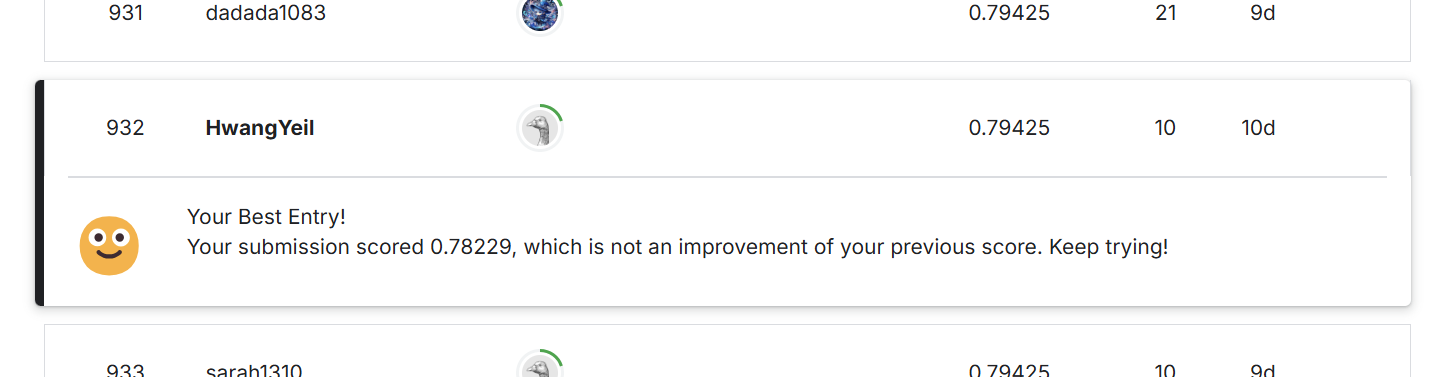